In [15]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Sklearn imports for evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# ============================================================================
# 1. 1. DATA EXPLORATION
# ============================================================================


In [16]:
def explore_dataset(base_path):
    """
    Explore the dataset structure and visualize class distribution
    """
    print("Dataset Structure:")
    print("==================")
    
    train_path = os.path.join(base_path, 'Training')
    test_path = os.path.join(base_path, 'Testing')
    
    # Get class names
    classes = sorted(os.listdir(train_path))
    print(f"Classes found: {classes}")
    
    # Count samples in training and testing sets
    train_counts = {}
    test_counts = {}
    
    for class_name in classes:
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)
        
        train_count = len(os.listdir(train_class_path))
        test_count = len(os.listdir(test_class_path))
        
        train_counts[class_name] = train_count
        test_counts[class_name] = test_count
        
        print(f"{class_name}: Training={train_count}, Testing={test_count}")
    
    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training set distribution
    ax1.bar(train_counts.keys(), train_counts.values(), color='skyblue', alpha=0.7)
    ax1.set_title('Training Set - Class Distribution')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)
    for i, v in enumerate(train_counts.values()):
        ax1.text(i, v + 10, str(v), ha='center', va='bottom')
    
    # Testing set distribution
    ax2.bar(test_counts.keys(), test_counts.values(), color='lightcoral', alpha=0.7)
    ax2.set_title('Testing Set - Class Distribution')
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Number of Images')
    ax2.tick_params(axis='x', rotation=45)
    for i, v in enumerate(test_counts.values()):
        ax2.text(i, v + 5, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return classes, train_counts, test_counts


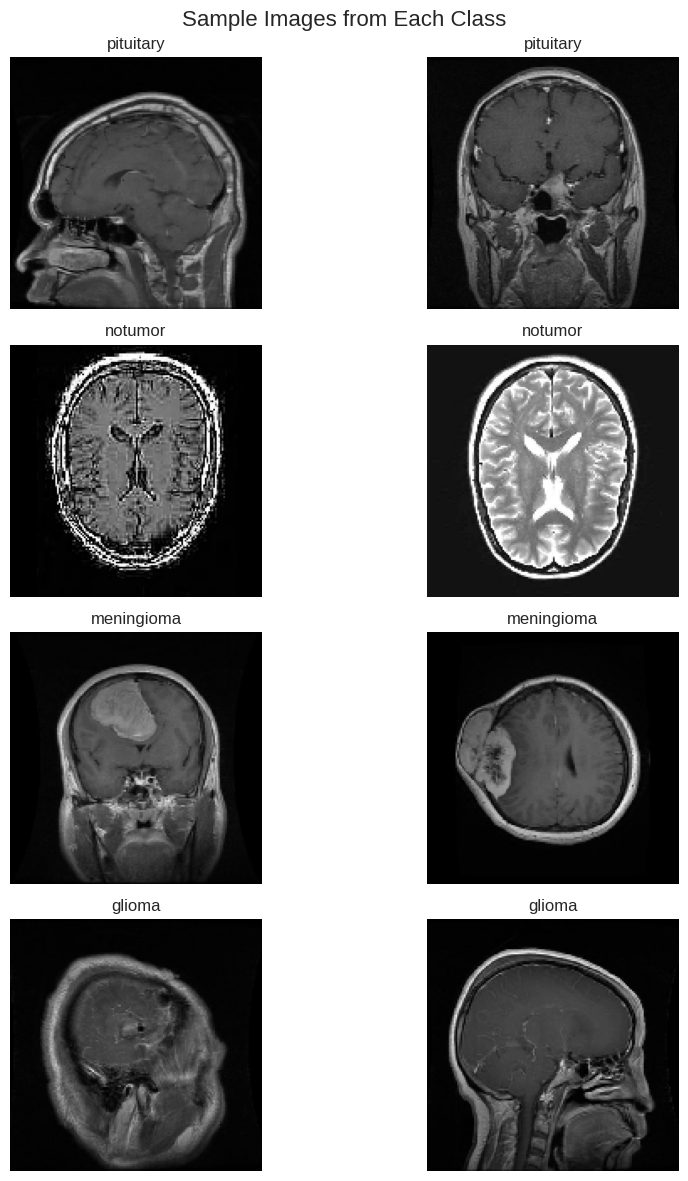

In [17]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

def display_sample_images(base_path, classes, n_samples=2):
    """
    Display sample images from each class
    """
    train_path = os.path.join(base_path, 'Training')
    
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(10, 12))
    fig.suptitle('Sample Images from Each Class', fontsize=16)
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(train_path, class_name)
        images = os.listdir(class_path)[:n_samples]
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(150, 150))
            
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{class_name}')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Dataset path
dataset_path = '/kaggle/input/brain-tumor-mri-dataset'

# Example explore_dataset function (since you’re calling it but didn’t define it yet)
def explore_dataset(base_path):
    train_path = os.path.join(base_path, 'Training')
    test_path = os.path.join(base_path, 'Testing')
    
    classes = os.listdir(train_path)
    train_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in classes}
    test_counts = {cls: len(os.listdir(os.path.join(test_path, cls))) for cls in classes}
    
    return classes, train_counts, test_counts

# Explore dataset
classes, train_counts, test_counts = explore_dataset(dataset_path)
display_sample_images(dataset_path, classes)


# ============================================================================
# 2. DATA PREPROCESSING 
# ============================================================================


In [18]:
def create_data_generators(dataset_path, img_size=(150, 150), batch_size=32):
    """
    Create data generators for training, validation, and testing
    """
    train_path = os.path.join(dataset_path, 'Training')
    test_path = os.path.join(dataset_path, 'Testing')
    
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2  # 20% for validation
    )
    
    # Testing data generator (only rescaling)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    
    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=42
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

# Create data generators
train_gen, val_gen, test_gen = create_data_generators(dataset_path)

print("Data Generators Created:")
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Testing samples: {test_gen.samples}")
print(f"Number of classes: {train_gen.num_classes}")
print(f"Class indices: {train_gen.class_indices}")


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data Generators Created:
Training samples: 4571
Validation samples: 1141
Testing samples: 1311
Number of classes: 4
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# =======================================
# 3. CNN MODEL ARCHITECTURE
# ======================================


In [19]:
def build_cnn_model(input_shape=(150, 150, 3), num_classes=4):
    """
    Build a CNN model for brain tumor classification
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build the model
model = build_cnn_model(num_classes=train_gen.num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("Model Architecture:")
print("==================")
model.summary()

# Plot model architecture (if graphviz is available)
try:
    tf.keras.utils.plot_model(model, to_file='model_architecture.png', 
                             show_shapes=True, show_layer_names=True)
    print("Model architecture saved as 'model_architecture.png'")
except:
    print("Could not save model architecture plot")


I0000 00:00:1757743481.126127      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757743481.126863      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,947,780 (26.50 MB)

 Trainable params: 6,945,796 (26.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

Model architecture saved as 'model_architecture.png'



# ============================================================================
# 4. TRAINING SETUP 
# ============================================================================


In [20]:
def setup_callbacks():
    """
    Setup training callbacks
    """
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            'best_brain_tumor_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    return callbacks

# Setup callbacks
callbacks = setup_callbacks()


# ============================================================================
# 5. MODEL TRAINING 
# ============================================================================


Starting Model Training...
Epoch 1/50


I0000 00:00:1757743490.948833     170 service.cc:148] XLA service 0x797f3401b060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757743490.950485     170 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757743490.950509     170 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757743491.750000     170 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/142 ━━━━━━━━━━━━━━━━━━━━ 37:40 16s/step - accuracy: 0.2500 - loss: 3.0148

I0000 00:00:1757743500.696354     170 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.5120 - loss: 1.4435
Epoch 1: val_accuracy improved from -inf to 0.25625, saving model to best_brain_tumor_model.h5
142/142 ━━━━━━━━━━━━━━━━━━━━ 77s 435ms/step - accuracy: 0.5123 - loss: 1.4422 - val_accuracy: 0.2562 - val_loss: 4.5309 - learning_rate: 0.0010
Epoch 2/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6250 - loss: 1.0797
Epoch 2: val_accuracy improved from 0.25625 to 0.31964, saving model to best_brain_tumor_model.h5
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6250 - loss: 1.0797 - val_accuracy: 0.3196 - val_loss: 4.2599 - learning_rate: 0.0010
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6171 - loss: 0.9804
Epoch 3: val_accuracy did not improve from 0.31964
142/142 ━━━━━━━━━━━━━━━━━━━━ 38s 271ms/step - accuracy: 0.6173 - loss: 0.9802 - val_accuracy: 0.2250 - val_loss: 2.2140 - learning_rate: 0.0010
Epoch 4/50
  1/142 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5938 - 

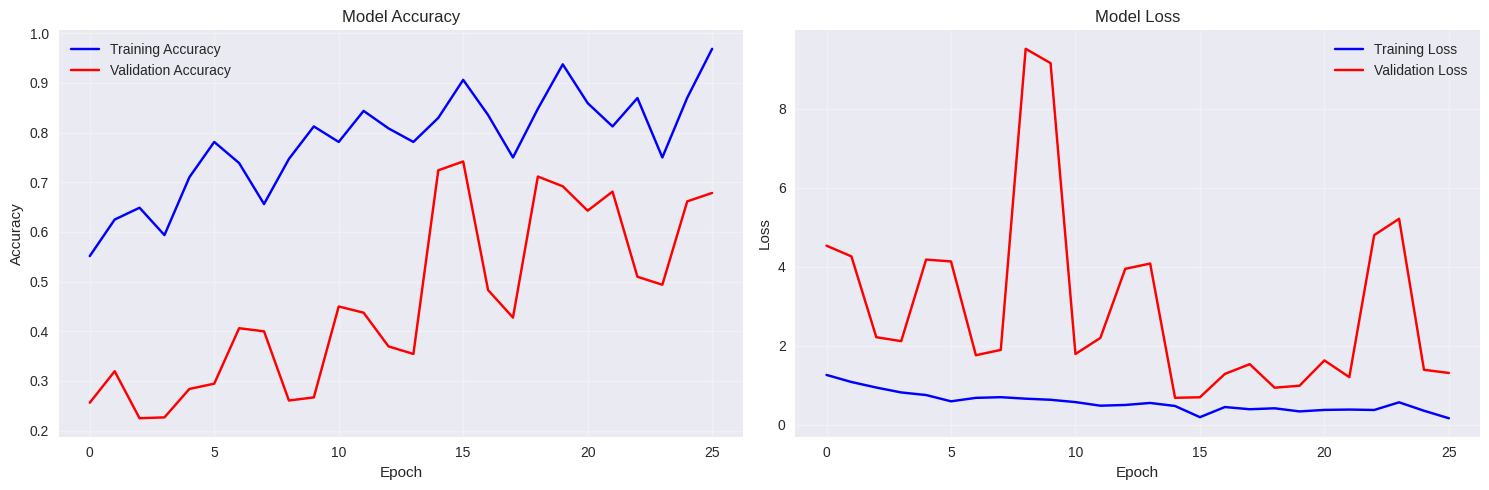

Best Validation Accuracy: 0.7420 at epoch 16


In [21]:
print("Starting Model Training...")
print("========================")

# Calculate steps per epoch
steps_per_epoch = train_gen.samples // train_gen.batch_size
validation_steps = val_gen.samples // val_gen.batch_size

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

# =================== 6. TRAINING VISUALIZATION ===================

def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print best metrics
    best_val_acc = max(history.history['val_accuracy'])
    best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")

plot_training_history(history)

# ============================================================================
# #  7. MODEL EVALUATION 
# ===========================================================================


Evaluating Model on Test Data...
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.5810 - loss: 1.1392
Test Loss: 0.7443
Test Accuracy: 0.7285
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.55      0.71       300
  meningioma       0.62      0.31      0.41       306
     notumor       0.80      0.98      0.88       405
   pituitary       0.60      1.00      0.75       300

    accuracy                           0.73      1311
   macro avg       0.75      0.71      0.69      1311
weighted avg       0.76      0.73      0.70      1311



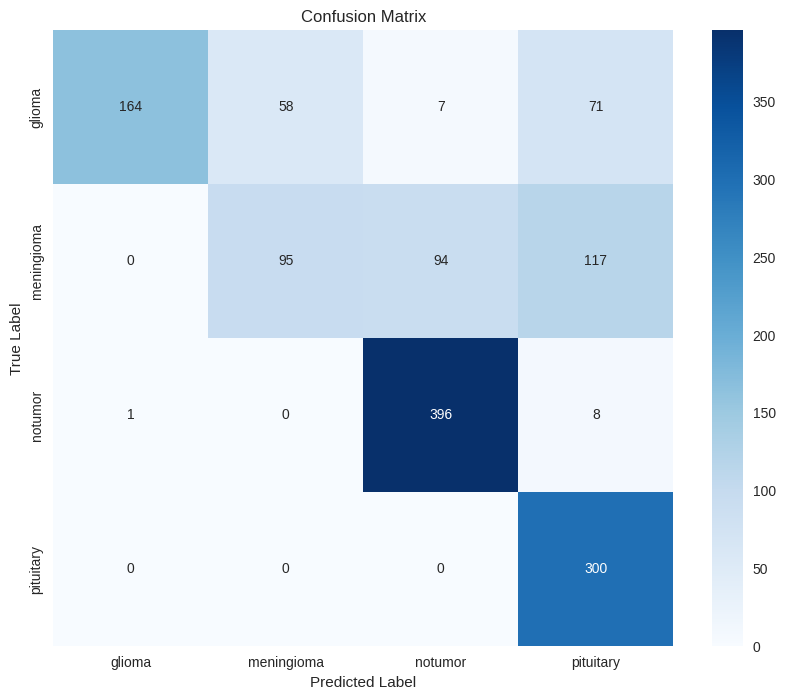

In [22]:
def evaluate_model(model, test_generator, class_names):
    """
    Evaluate the model on test data and generate reports
    """
    print("Evaluating Model on Test Data...")
    print("===============================")
    
    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get true labels
    true_classes = test_generator.classes
    
    # Classification report
    print("\nClassification Report:")
    print("=====================")
    print(classification_report(true_classes, predicted_classes, 
                              target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return predictions, predicted_classes, true_classes

# Get class names
class_names = list(test_gen.class_indices.keys())

# Evaluate the model
predictions, predicted_classes, true_classes = evaluate_model(model, test_gen, class_names)


# ============================================================================
# 8. PREDICTION VISUALIZATION  
# ============================================================================


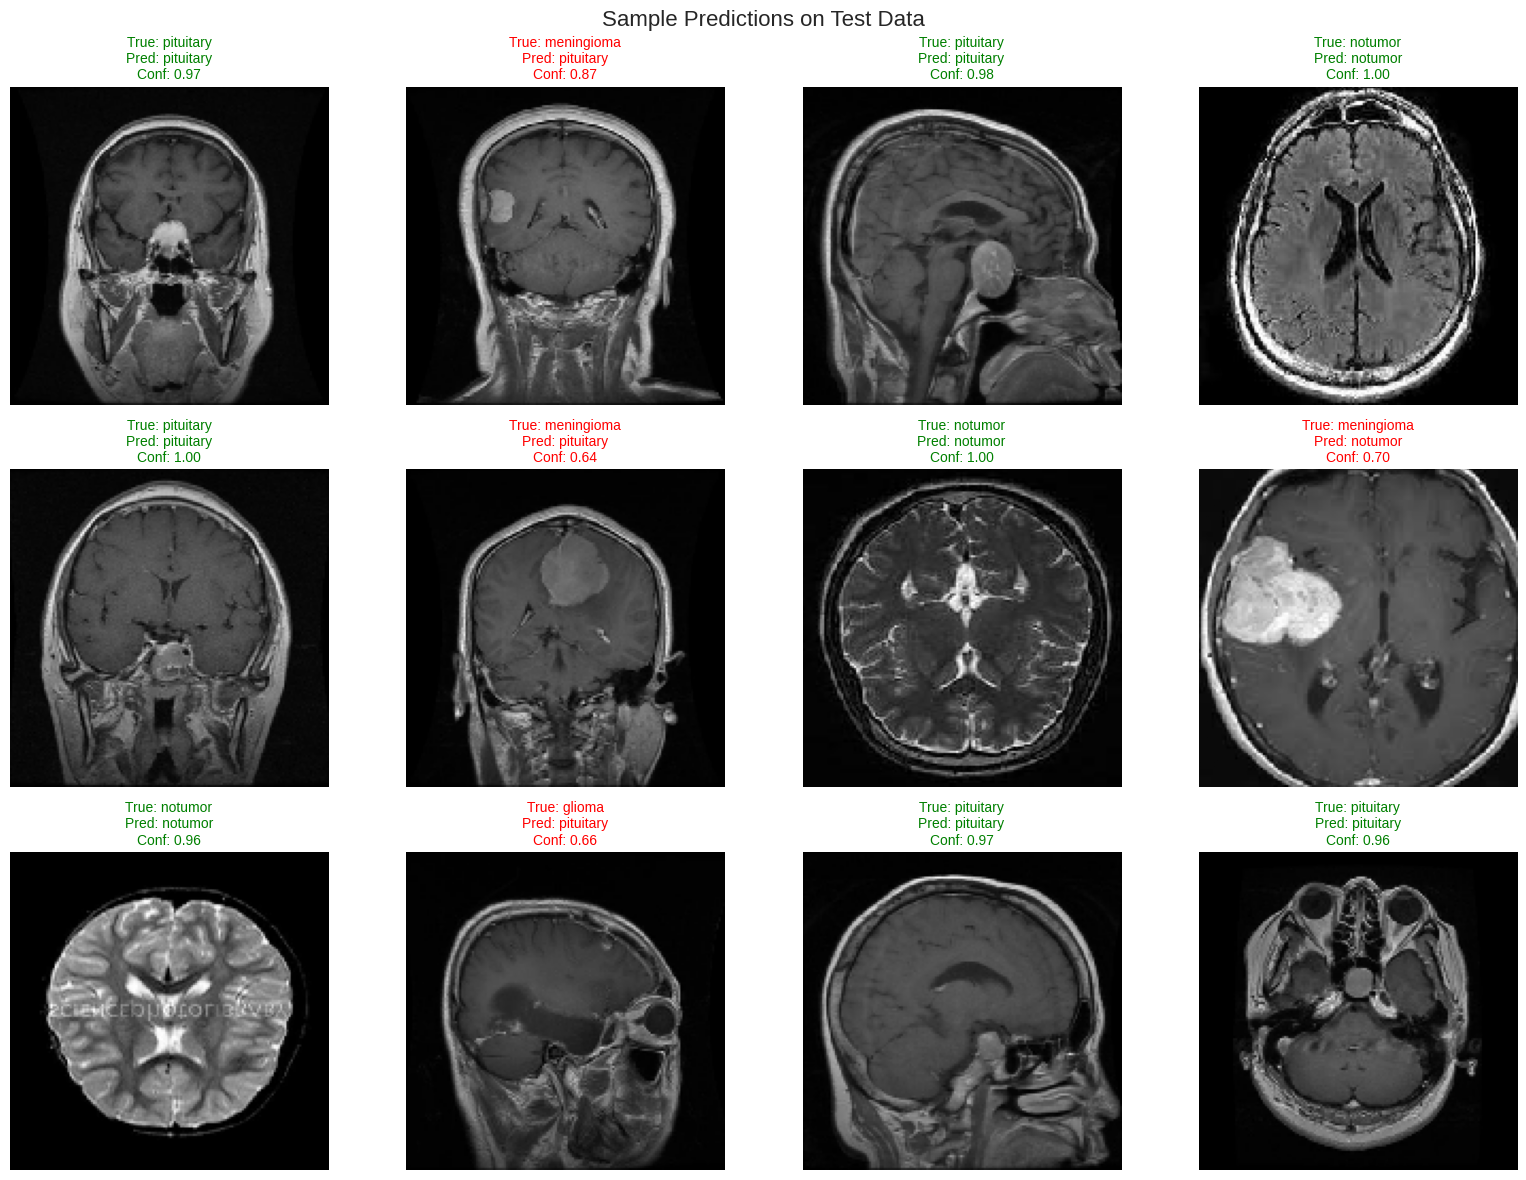

In [23]:
def display_predictions(test_generator, predictions, predicted_classes, true_classes, 
                       class_names, n_samples=12):
    """
    Display sample predictions with true and predicted labels
    """
    # Reset generator to get images in order
    test_generator.reset()
    
    # Get sample indices
    sample_indices = np.random.choice(len(predictions), n_samples, replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Sample Predictions on Test Data', fontsize=16)
    axes = axes.ravel()
    
    for i, idx in enumerate(sample_indices):
        # Get the image
        batch_index = idx // test_generator.batch_size
        image_index = idx % test_generator.batch_size
        
        # Get batch
        test_generator.reset()
        for _ in range(batch_index + 1):
            batch_images, batch_labels = next(test_generator)
        
        if image_index < len(batch_images):
            image = batch_images[image_index]
            
            true_label = class_names[true_classes[idx]]
            pred_label = class_names[predicted_classes[idx]]
            confidence = predictions[idx][predicted_classes[idx]]
            
            axes[i].imshow(image)
            
            # Color coding: green for correct, red for incorrect
            color = 'green' if true_label == pred_label else 'red'
            axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}', 
                            color=color, fontsize=10)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample predictions
display_predictions(test_gen, predictions, predicted_classes, true_classes, class_names)


In [24]:
def model_summary_report(history, test_accuracy, class_names, true_classes, predicted_classes):
    """
    Generate a comprehensive model performance summary
    """
    print("\n" + "="*50)
    print("         MODEL PERFORMANCE SUMMARY")
    print("="*50)
    
    # Training summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    
    print(f"Final Training Accuracy:   {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Best Validation Accuracy:  {best_val_acc:.4f}")
    print(f"Test Accuracy:             {test_accuracy:.4f}")
    
    # Per-class accuracy
    print(f"\nPer-Class Performance:")
    print("-" * 30)
    
    for i, class_name in enumerate(class_names):
        class_indices = np.where(true_classes == i)[0]
        class_predictions = predicted_classes[class_indices]
        class_accuracy = np.mean(class_predictions == i)
        print(f"{class_name:12}: {class_accuracy:.4f}")
    
    # Overall statistics
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    
    print(f"\nModel Statistics:")
    print("-" * 20)
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
    
    print("\n" + "="*50)

# Generate final summary
model_summary_report(history, 
                    model.evaluate(test_gen, verbose=0)[1], 
                    class_names, 
                    true_classes, 
                    predicted_classes)


         MODEL PERFORMANCE SUMMARY
Final Training Accuracy:   0.9688
Final Validation Accuracy: 0.6786
Best Validation Accuracy:  0.7420
Test Accuracy:             0.7285

Per-Class Performance:
------------------------------
glioma      : 0.5467
meningioma  : 0.3105
notumor     : 0.9778
pituitary   : 1.0000

Model Statistics:
--------------------
Total Parameters:     6,947,780
Trainable Parameters: 6,945,796
Total Epochs Trained: 26

